# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

In [1]:
# pip install --upgrade ipykernel

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [2]:
# !pip install folium
# !pip install ipython==6.2.1
# !pip install jedi==0.17.2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [6]:
test = pd.read_csv('nyc-taxi-trip-duration/test.csv')
train = pd.read_csv('nyc-taxi-trip-duration/train.csv')
sample_submission = pd.read_csv('nyc-taxi-trip-duration/sample_submission.csv') 

In [7]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [8]:
train.drop(columns=['dropoff_datetime'], inplace=True)

In [9]:
train.pickup_datetime = pd.to_datetime(train.pickup_datetime)
test.pickup_datetime = pd.to_datetime(test.pickup_datetime)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

CPU times: user 1.99 s, sys: 72.5 ms, total: 2.07 s
Wall time: 2 s


<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

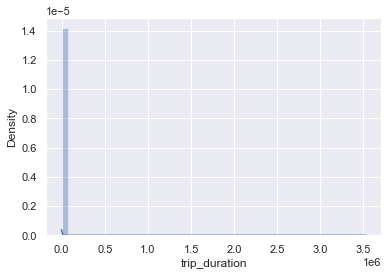

In [10]:
%%time
sns.distplot(train.trip_duration)
# у нас есть выбросы (тяжелые хвосты), которые мешают оценить распределение


**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

In [11]:
# мы увидем ниже, что распределение является нормальным (+-), если оно логирифмированно

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Ниже картинка

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

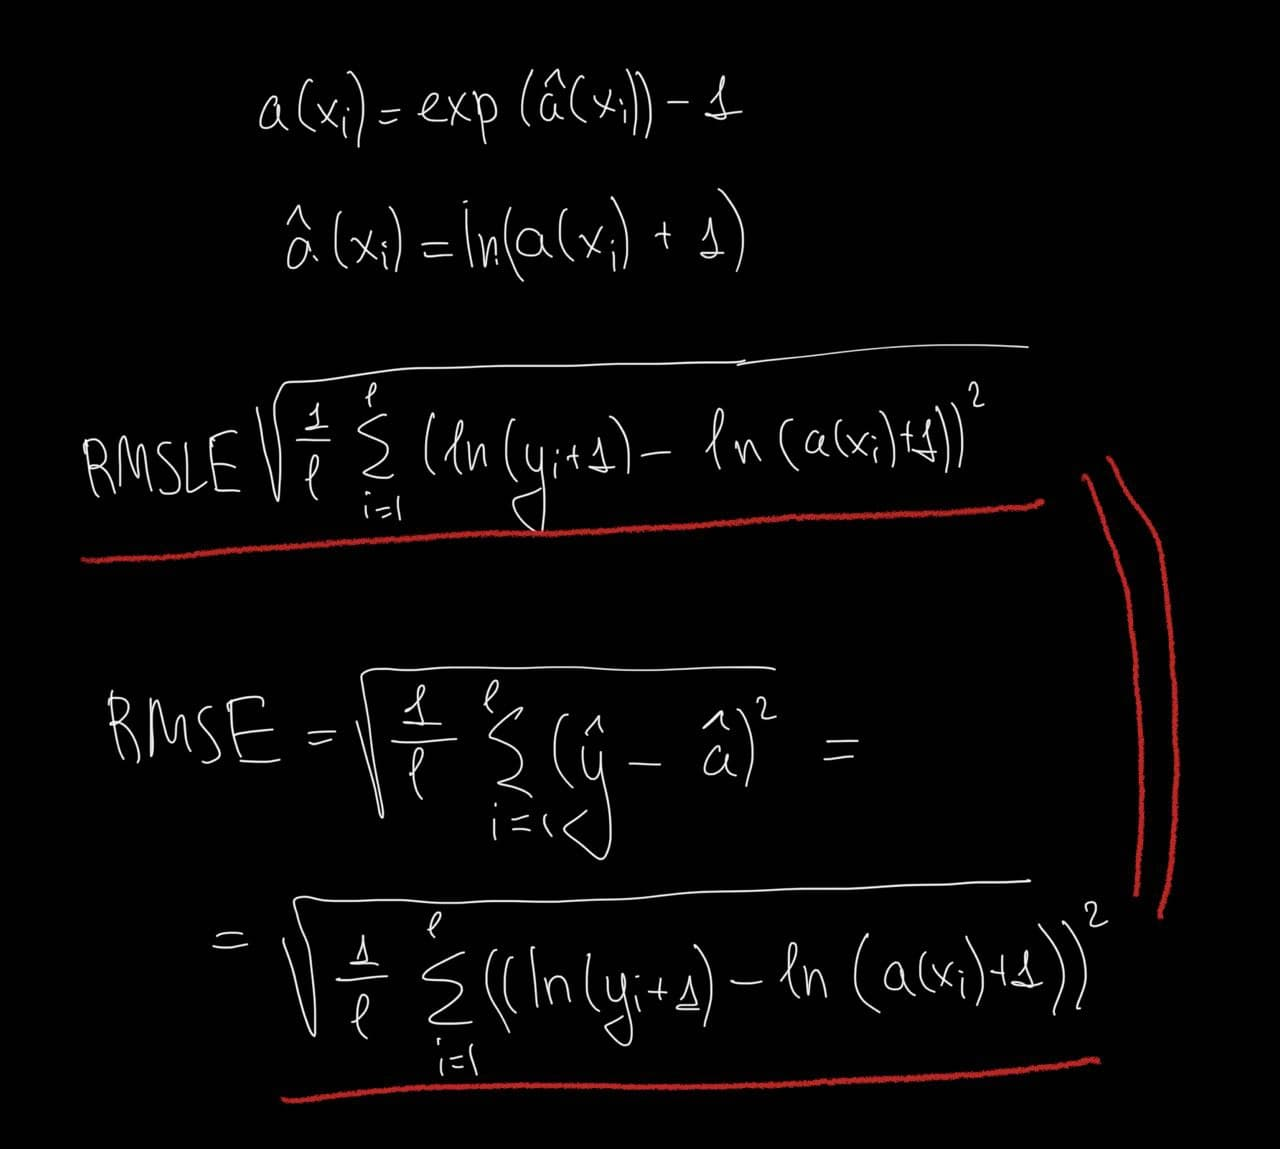

In [12]:
from IPython.display import Image
Image(filename = "photo_2021-10-11_14-52-33.jpg", width=400, height=400)
#![title](photo_2021-10-11_14-52-33.jpg)

<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

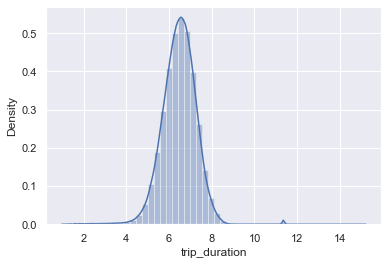

In [13]:
sns.distplot(np.log1p(train.trip_duration + 1))
# красота!!

In [14]:
train['log_trip_duration'] = np.log1p(train.trip_duration + 1)

In [15]:
train.drop(columns=['trip_duration'], inplace=True)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [16]:
from sklearn import metrics

y = train.log_trip_duration.values

metrics.mean_squared_error(y, np.median(y) * np.ones(y.shape), squared=False)

0.792914638580591

In [17]:
metrics.mean_squared_error(y, np.mean(y) * np.ones(y.shape), squared=False)

0.7923870986444395

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [18]:
#sns.countplot(x=train.pickup_datetime, hew=train.pickup_datetime) 

In [19]:
train = train.sort_values('pickup_datetime') # понадобится для некоторых графиков, однако на точность модели не поменяет
train['trip'] = 1

In [20]:
date_trips = pd.DataFrame((
    train.set_index('pickup_datetime')
    .resample('D')
    .sum()
))[['trip']]

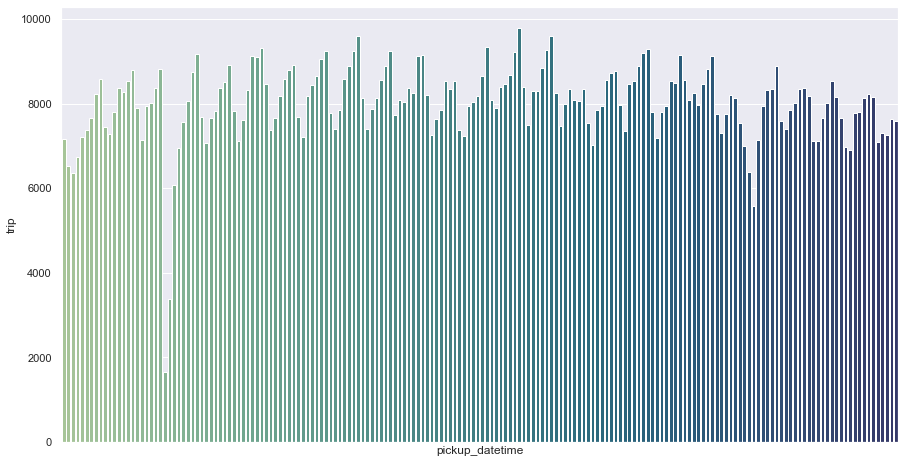

In [21]:
plt.figure(figsize = (15,8))
ax = sns.barplot(date_trips.index, date_trips.trip, palette='crest')
plt.xticks(rotation=90)
plt.tick_params(
    axis='x',          # уберем нижние цифры в графике, чтобы не было черной полосы
    which='both',      # в целом, по графику понятно общее движение
    labelbottom=False)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [22]:
date_trips[date_trips['trip'] < 6000] # по графику видно, что количество поездок в эти дни < 6000

# 23, 24 января
# https://www.usatoday.com/story/weather/2016/01/23/blizzard-continues-slam-east-coast/79217258/
# Была ужасная метель

# 30 мая - сбой компьютерной системы в аэропорту

trip
pickup_datetime      
2016-01-23       1648
2016-01-24       3383
2016-05-30       5570

In [23]:
hour_trip = pd.DataFrame((train.set_index('pickup_datetime').resample('h').sum()))[['trip']]
hour_trip = hour_trip.reset_index()

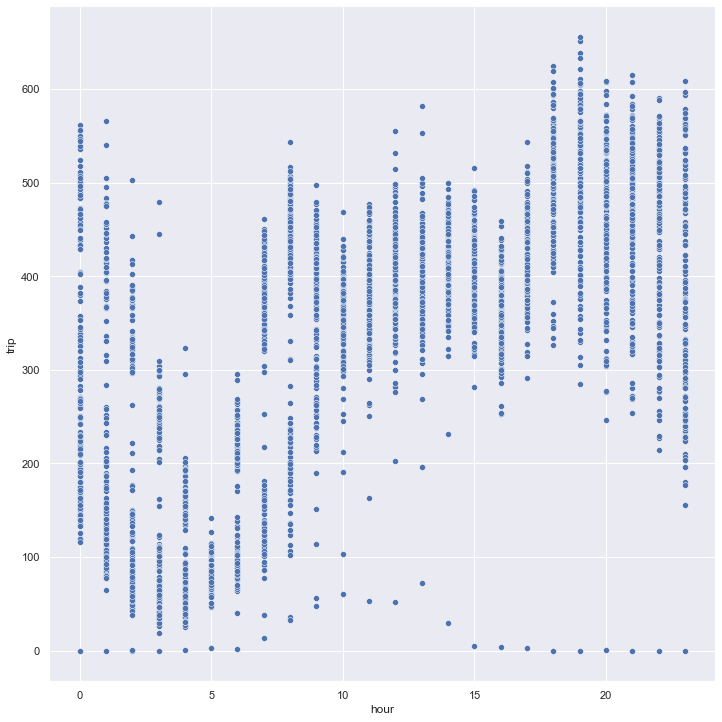

In [24]:
hour_trip['hour'] = hour_trip['pickup_datetime'].dt.hour
# hour_trip.groupby(['hour']).sum()

sns.relplot(
    x='hour', 
    y='trip',
    data=hour_trip,
    height = 10
)

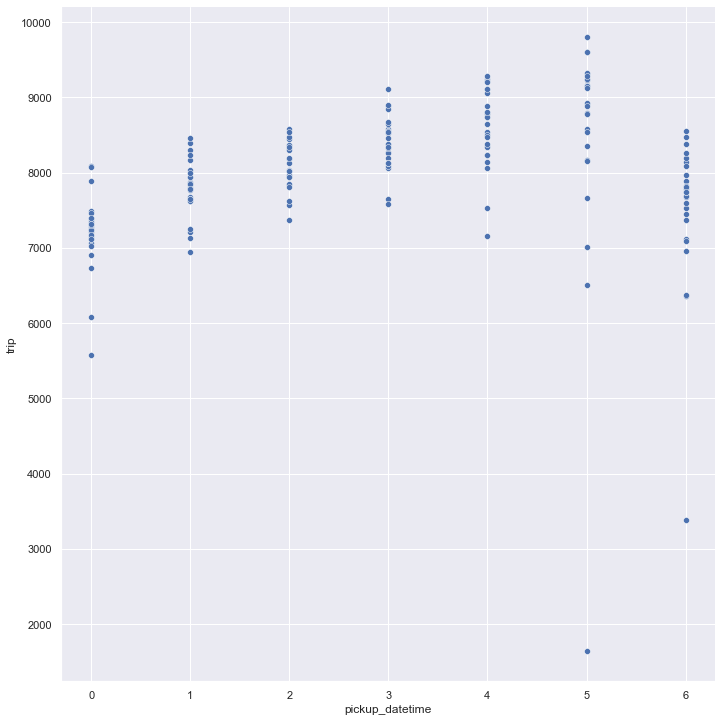

In [25]:
import datetime
sns.relplot(
    x=date_trips.index.weekday, 
    y='trip', 
    data=date_trips,
    height = 10
)

# Monday = 0
# ...
# Sunday = 6

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

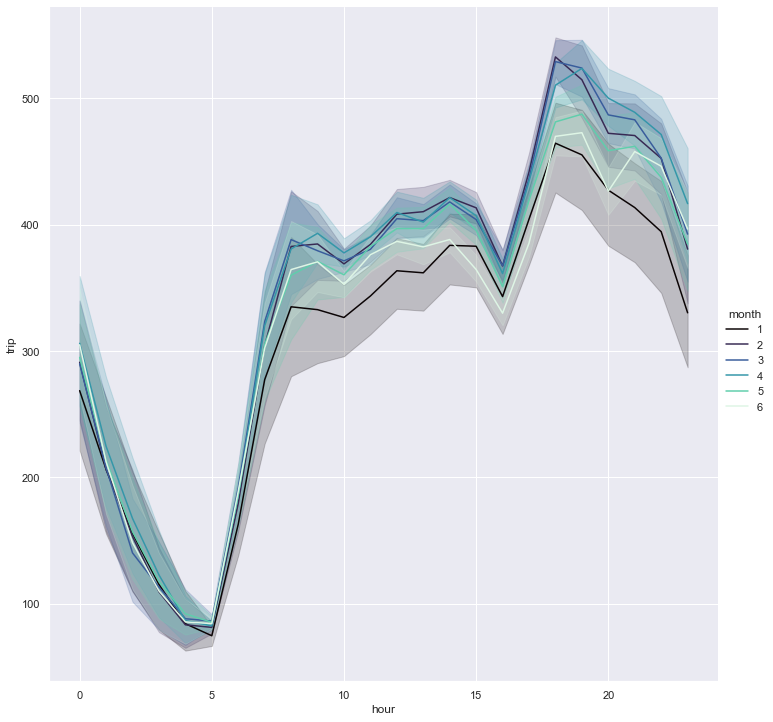

In [26]:
hour_trip['month'] = hour_trip['pickup_datetime'].dt.month

sns.relplot(
    x='hour', 
    y='trip',
    hue='month',
    data=hour_trip,
    height = 10,
    kind='line',
    palette='mako'
)

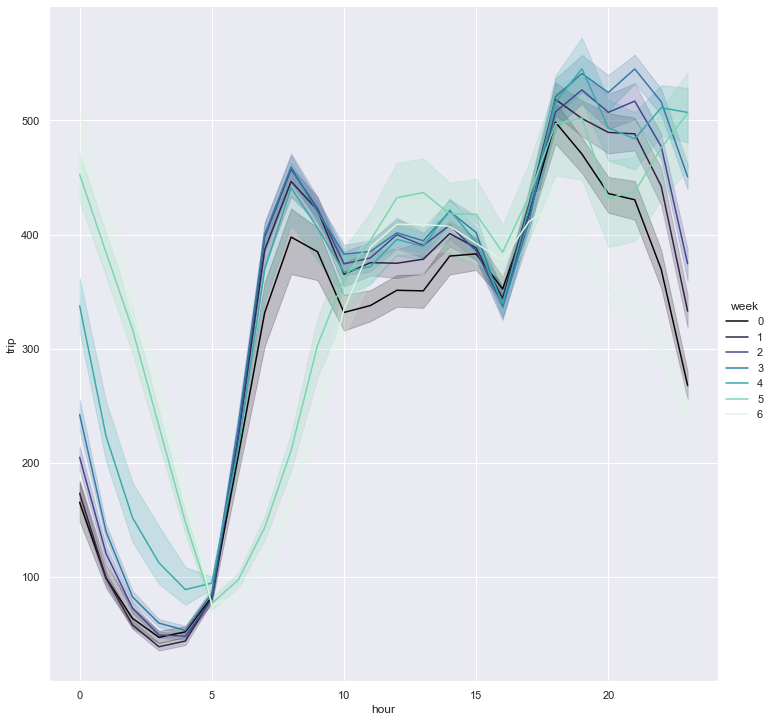

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

hour_trip['week'] = hour_trip['pickup_datetime'].dt.dayofweek

sns.relplot(
    x='hour', 
    y='trip',
    hue= 'week',
    data=hour_trip,
    kind='line',
    height = 10,
    palette='mako'
)

sns.set(rc={'figure.figsize':(15,15)})


In [28]:
# на первом графике видно, что бОльшая часть поездок происходит во второй половине дня (утрром наоборот спад)
# ближе к концу рабочей недели люди в среднем начинают чаще заказывать такси, а на выходных немного идет на спад
# для всех месяцев история примерно аналогичная
# На последнем графике выделяются выходные (графики смещены)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [29]:
from sklearn.model_selection import train_test_split

train = train.drop(columns=["id"])

y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [30]:
# средний логарифм времени от дня недели 

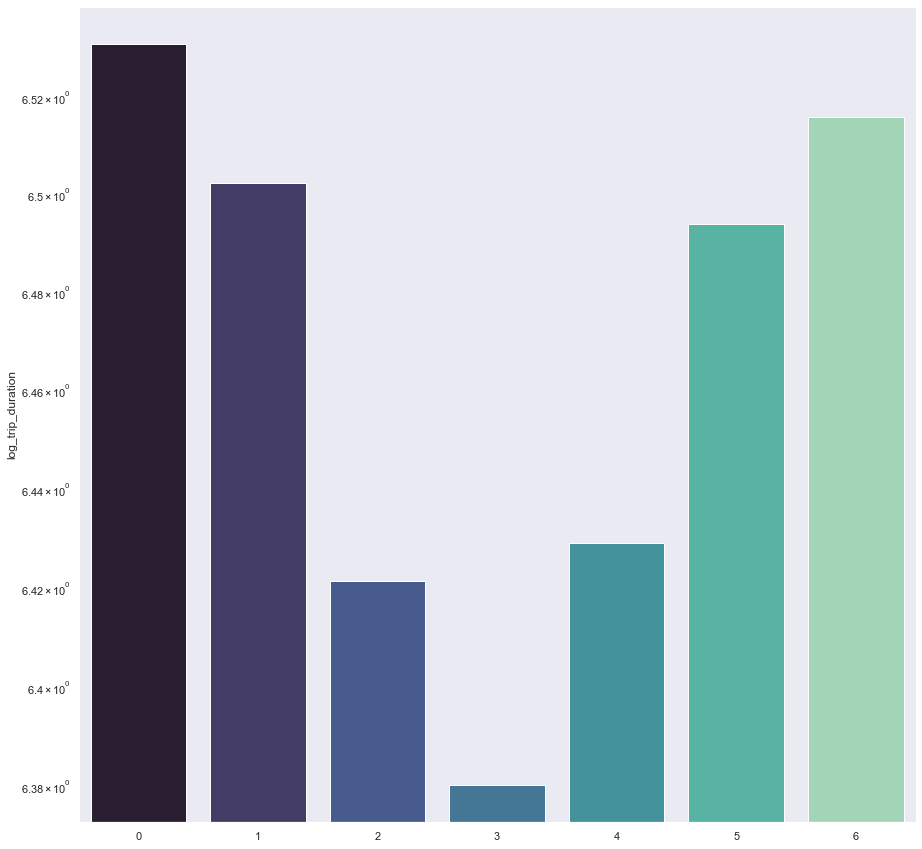

In [31]:
# зависимость среднего логарифма от дня недели
ax = sns.barplot(
    x=train['pickup_datetime'].dt.dayofweek.unique(), 
    y=train.groupby(
        by=train['pickup_datetime']
        .dt
        .dayofweek)
    .mean()
    ['log_trip_duration'],
    palette='mako'
    )

ax.set_yscale('log')

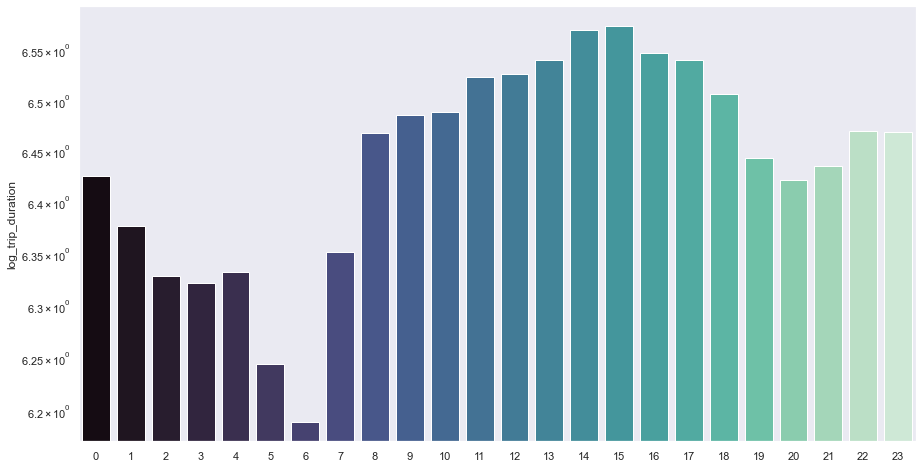

In [32]:
# для часа в сутках
plt.figure(figsize = (15,8))

ax = sns.barplot(
    x=train['pickup_datetime'].dt.hour.unique(), 
    y=train.groupby(
        by=train['pickup_datetime']
        .dt
        .hour)
    .mean()
    ['log_trip_duration'],
    palette='mako'
    )

ax.set_yscale('log')
plt.show()


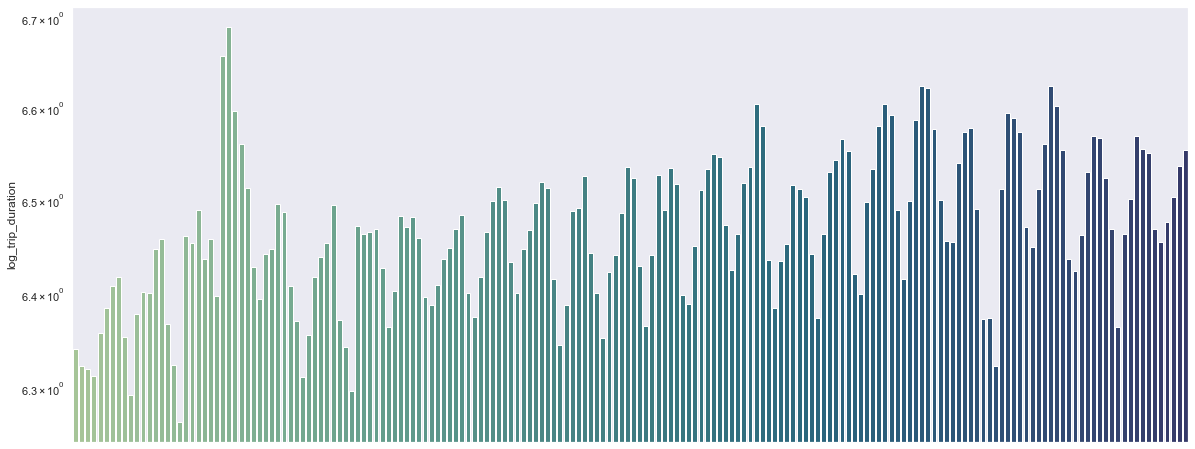

In [33]:
# ддя дня в году
plt.figure(figsize = (20,8))

ax = sns.barplot(
    x=train['pickup_datetime'].dt.dayofyear.unique(), 
    y=train.groupby(
        by=train['pickup_datetime']
        .dt
        .dayofyear)
    .mean()
    ['log_trip_duration'],
    palette='crest'
    )

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom=False)

ax.set_yscale('log')
plt.show()

# 30-ого мая виден упадок

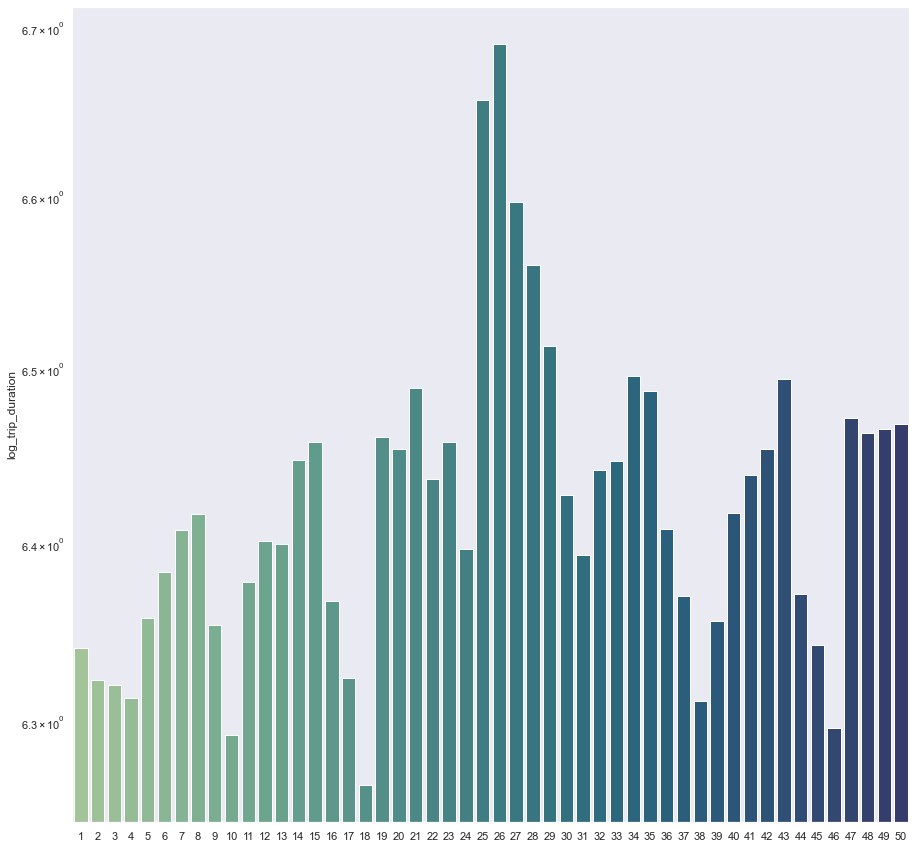

In [34]:
ax = sns.barplot(
    x=train['pickup_datetime'].dt.dayofyear.unique()[:50], 
    y=train.groupby(
        by=train['pickup_datetime']
        .dt
        .dayofyear).mean()[:50]
    ['log_trip_duration'],
    palette='crest'
    )
ax.set_yscale('log')

In [35]:
# да, графики от количества поездок и от времени поездки чем-то схожи, поскольку чем больше машин на дороге, чем больше пробок, тем дольше поездка
# в два аномальных дня была длительность поездки в целом средняя,а вот следующие несколько дней длительность поездки резкл возрасла (видимо, из-за снега)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [36]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['month'] = train['pickup_datetime'].dt.month
train['hour'] = train['pickup_datetime'].dt.hour
train['dayofyear'] = train['pickup_datetime'].dt.dayofyear
train['anomaly'] = 0

train.loc[
    ((
        train['pickup_datetime']
        .dt
        .date == datetime.date(2016, 1, 23)
    )|
    (
        train['pickup_datetime']
        .dt
        .date == datetime.date(2016, 1, 24)
    )|
    (
        train['pickup_datetime']
        .dt
        .date == datetime.date(2016 , 5, 30)
    )),
    'anomaly'
] = 1

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

In [37]:
# все эти признаки являются категориальными (потому что для нас важно знать, в какой именно час/день/месяц была поездка), нормализация этих данных
# была бы бесмысленной

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [38]:
# код взят с семинаров
categorical = train.columns[-5:-1]

numeric_data = train.select_dtypes([np.number])
numeric_features = numeric_data.columns

In [39]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [40]:
X_train[categorical]

dayofweek  month  hour  dayofyear
1199672          1      4    19        103
1084126          1      3     8         82
560811           6      3    20         87
1242034          5      5    16        142
1071906          1      1    10         26
...            ...    ...   ...        ...
1027568          3      6    16        168
944233           6      5    10        143
1395402          4      3    19         78
1195346          0      5    19        130
318249           2      6    16        174

[1021050 rows x 4 columns]

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train_part = X_train[X_train.columns[-5:]]

X_test_part = X_test[X_test.columns[-5:]]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features[-1:])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_part, y_train)

y_pred = model.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7851


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [42]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m


In [43]:
show_circles_on_map(train.sample(1000, random_state=100), "pickup_latitude", "pickup_longitude", "blue")

In [44]:
show_circles_on_map(train.sample(1000, random_state=100), "dropoff_latitude", "dropoff_longitude", "red")

**Вопрос**: Какие две точки выделяются на карте?

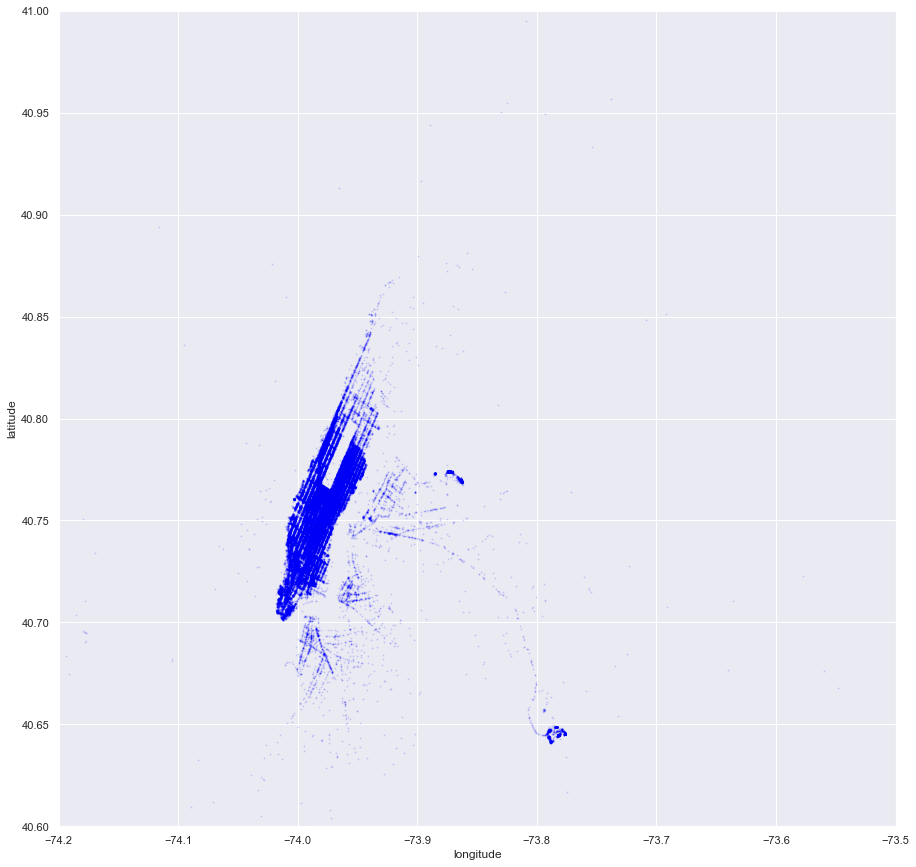

In [45]:
# на этом графике видно значительно лучше! Это точки двух аэропортов

N = 100000
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)
city_long_border = (-74.20, -73.50)
city_lat_border = (40.60, 41.00)

plt.figure(figsize=(15,15))
plt.scatter(X_train['pickup_longitude'].values[:N], X_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

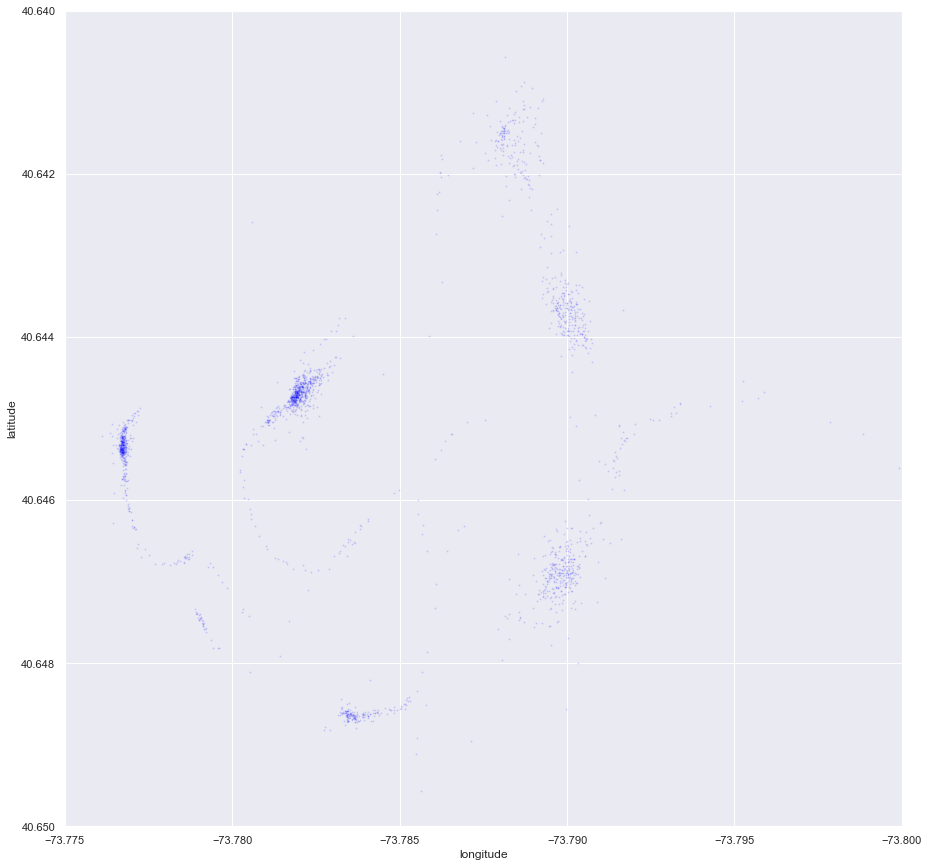

In [46]:
# нашли координаты для одной точки (понадобится для сл задания)

N = 100000

city_long_border = (-73.775, -73.80)
city_lat_border = (40.65, 40.64)

plt.figure(figsize=(15,15))
plt.scatter(X_train['pickup_longitude'].values[:N], X_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

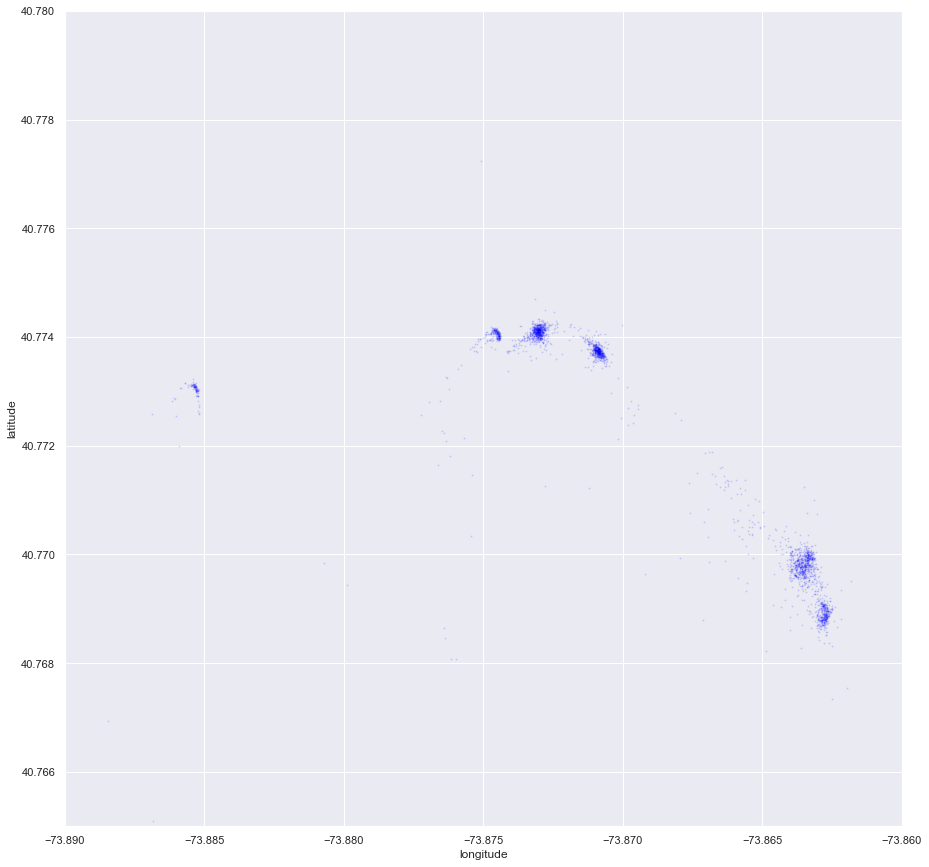

In [47]:
# координаты второй точки (понадобится для сл задания)

N = 100000
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)
city_long_border = (-73.89, -73.86)
city_lat_border = (40.765, 40.78)

plt.figure(figsize=(15,15))
plt.scatter(X_train['pickup_longitude'].values[:N], X_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Точки около аэропорта

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [48]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [49]:
train['haversine'] = haversine_array(train['pickup_longitude'], 
                          train['pickup_latitude'], 
                          train['dropoff_longitude'], 
                          train['dropoff_latitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [50]:
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [51]:
train[['haversine', 'log_haversine', 'log_trip_duration']].corr() 

haversine  log_haversine  log_trip_duration
haversine           1.000000       0.858161           0.521709
log_haversine       0.858161       1.000000           0.676793
log_trip_duration   0.521709       0.676793           1.000000

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<AxesSubplot:>

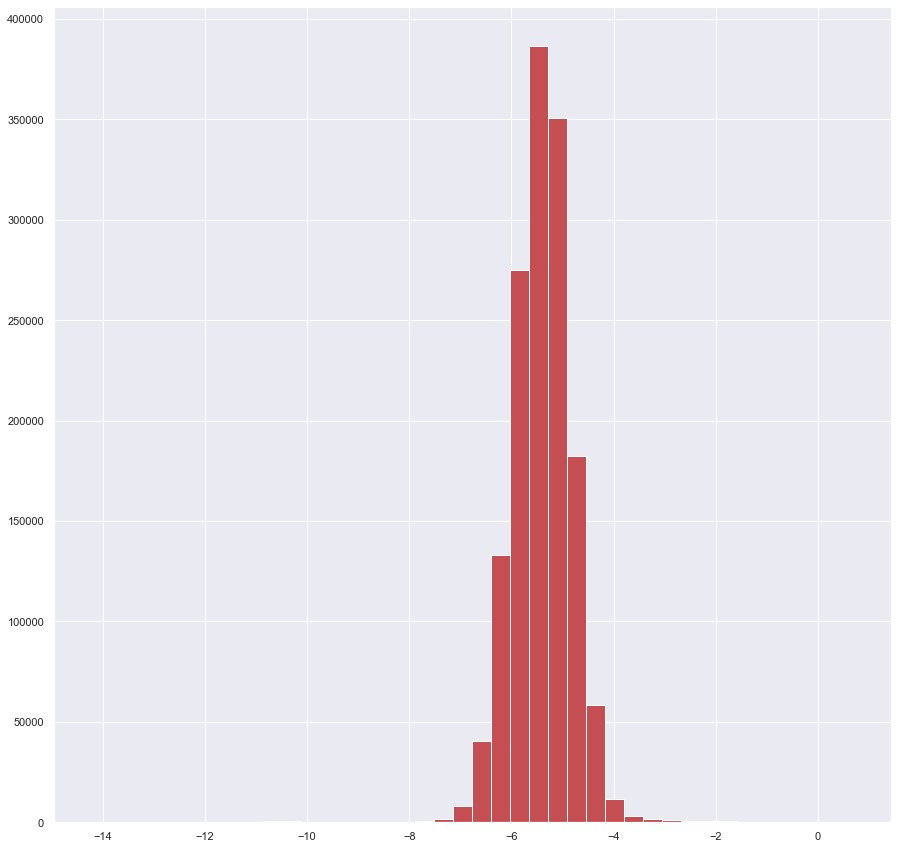

In [52]:
# trip_duration мы уже удалили из выборки и больше с ним не работаем, посчитаем разность логарифмов
train['log_v_s'] = train['log_haversine'] - train['log_trip_duration']
#sns.histplot(X_train_y['v_s'])
train['log_v_s'].hist(bins=40, color='r')

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [53]:
train['log_v_s'].quantile([.01, .99])

0.01   -6.729802
0.99   -4.075247
Name: log_v_s, dtype: float64

<AxesSubplot:>

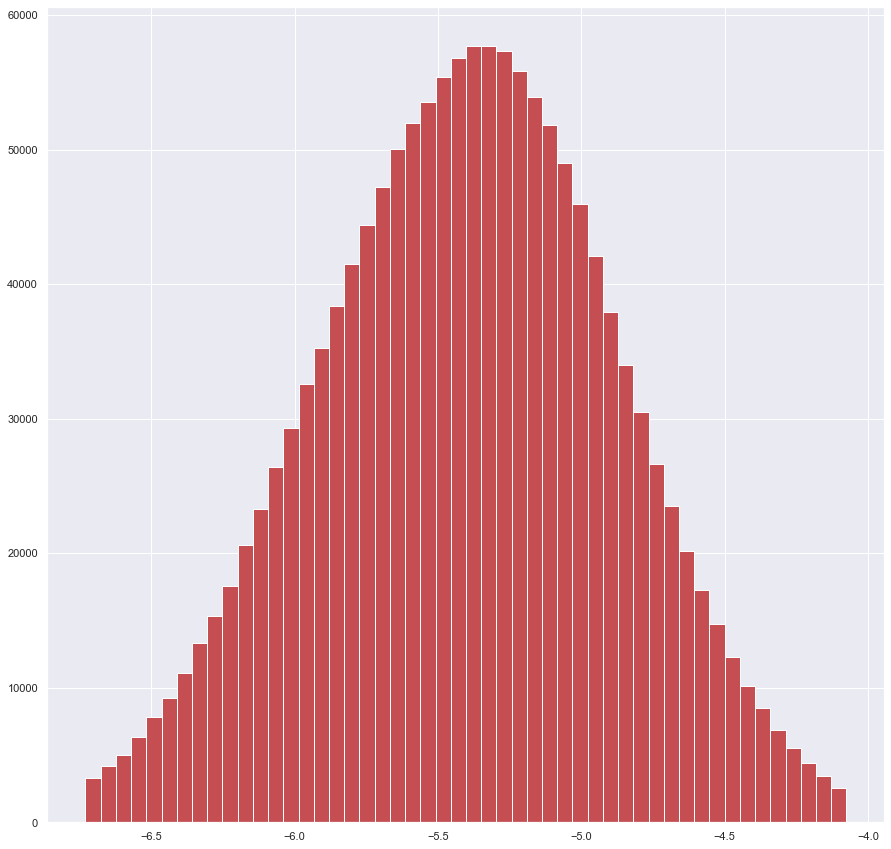

In [54]:
train[
    ((train['log_v_s'] < -4.075247)&
    (train['log_v_s'] > -6.729802))
]['log_v_s'].hist(bins=50, color='r') 

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [55]:
heatmap_data = pd.DataFrame(train.groupby(by=['dayofweek', 'hour']).median()['log_v_s'])
heatmap_data = heatmap_data.reset_index()

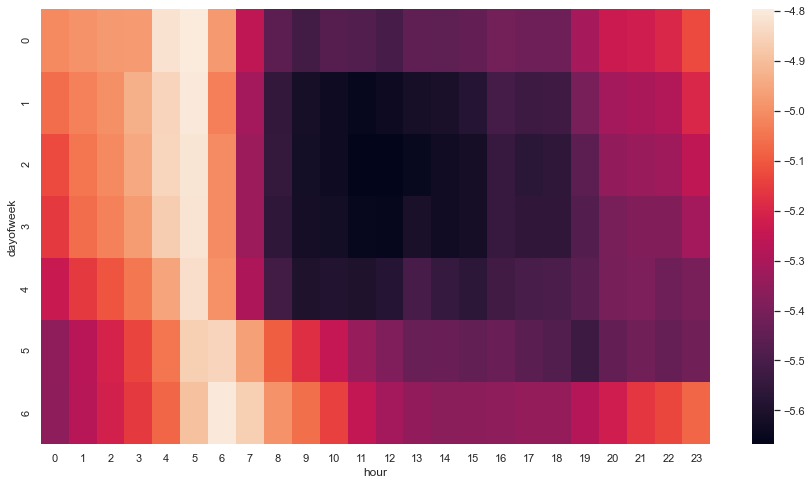

In [56]:
plt.figure(figsize = (15,8))

sns.heatmap(heatmap_data.pivot(index='dayofweek', columns='hour')['log_v_s'])

plt.show()


# прикольно, насколько четко видны час пики во время рабочего времени

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [57]:
#потому что скорость напрямую зависит от таргета

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [58]:
# минимальная скорость во время рабочего дня, максимальная - рано-рано утром

In [59]:
train['traffic_jam'] = 0

train.loc[
    ((train['hour'] >= 7) &
        (train['hour'] < 20) &
        (train['dayofweek'] < 5)),
    'traffic_jam'
       ] = 1

In [60]:
train['free_road'] = 0

train.loc[(
    ((train['hour'] > 3) &
        (train['hour'] < 6) &
        (train['dayofweek'] < 5)) |
    ((train['hour'] > 4) &
        (train['hour'] <= 7) &
        (train['dayofweek'] > 4))),
    'free_road'
       ] = 1


**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [61]:
train['from_airport_1'] = 0
train['from_airport_2'] = 0

train.loc[((train['pickup_longitude'] <= -73.86) &
        (train['pickup_longitude'] >= -73.89) &
        (train['pickup_latitude'] <= 40.78) &
        (train['pickup_latitude'] >= 40.765)),
            'from_airport_1' 
       ] = 1

train.loc[((train['pickup_longitude'] >= -73.80) &
        (train['pickup_longitude'] <= -73.775) &
        (train['pickup_latitude'] <= 40.65) &
        (train['pickup_latitude'] >= 40.64)),
            'from_airport_2' 
       ] = 1

train['to_airport_1'] = 0
train['to_airport_2'] = 0

train.loc[((train['dropoff_longitude'] < -73.86) &
        (train['dropoff_longitude'] > -73.89) &
        (train['dropoff_latitude'] < 40.78) &
        (train['dropoff_latitude'] > 40.765)),
        'to_airport_1'
       ] = 1


train.loc[((train['dropoff_longitude'] > -73.80) &
        (train['dropoff_longitude'] < -73.775) &
        (train['dropoff_latitude'] < 40.65) &
        (train['dropoff_latitude'] > 40.64)),
            'to_airport_2'
       ] = 1

In [62]:
airport = train.copy()
airport['target'] = np.log(y_train)

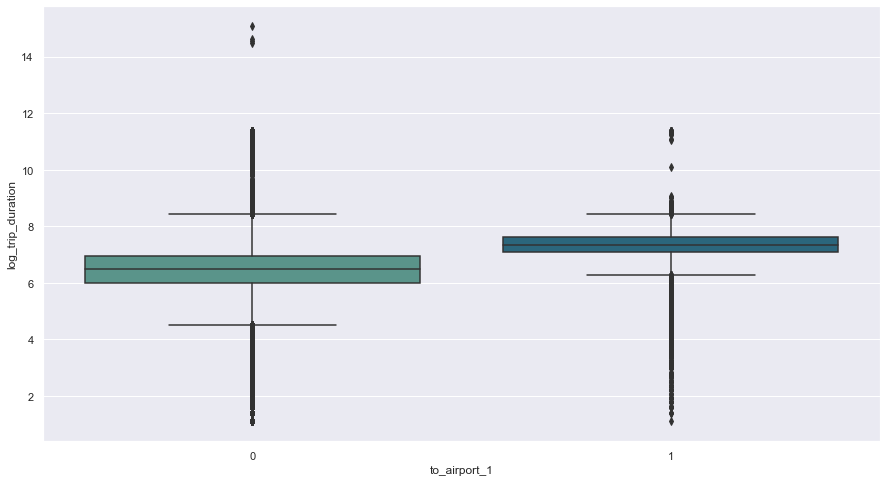

In [63]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="to_airport_1", y="log_trip_duration",
                  data=airport, palette="crest")

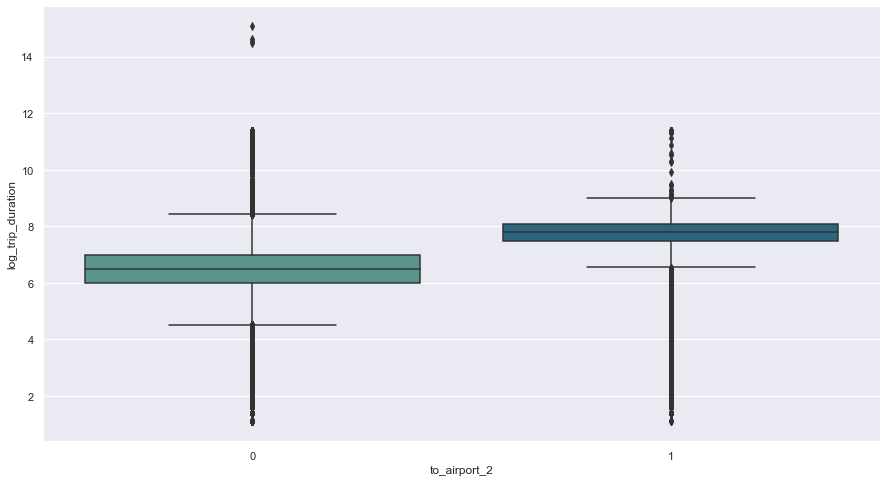

In [64]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="to_airport_2", y="log_trip_duration",
                  data=airport, palette="crest")

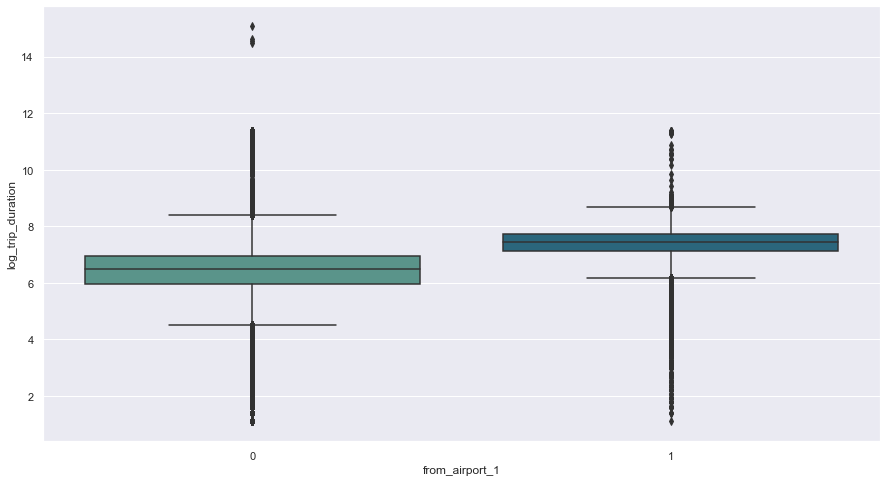

In [65]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="from_airport_1", y="log_trip_duration",
                  data=airport, palette="crest")

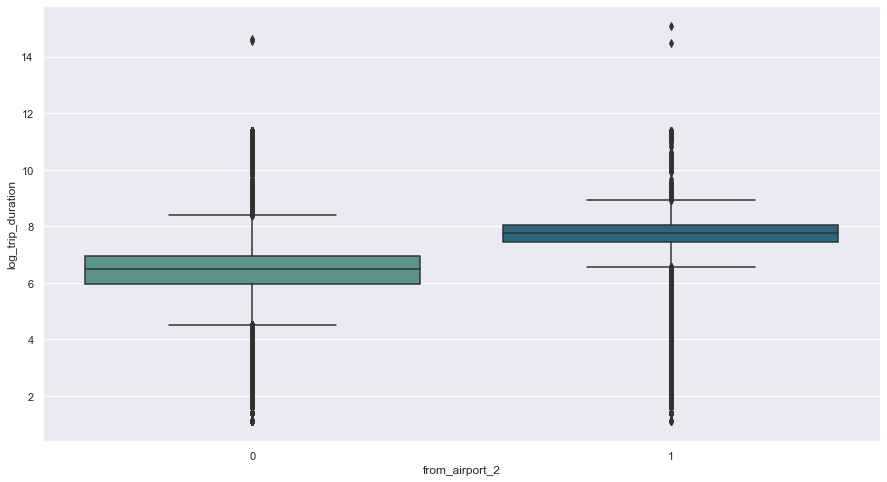

In [66]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="from_airport_2", y="log_trip_duration",
                  data=airport, palette="crest")

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

In [67]:
# графики достаточно показательны

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

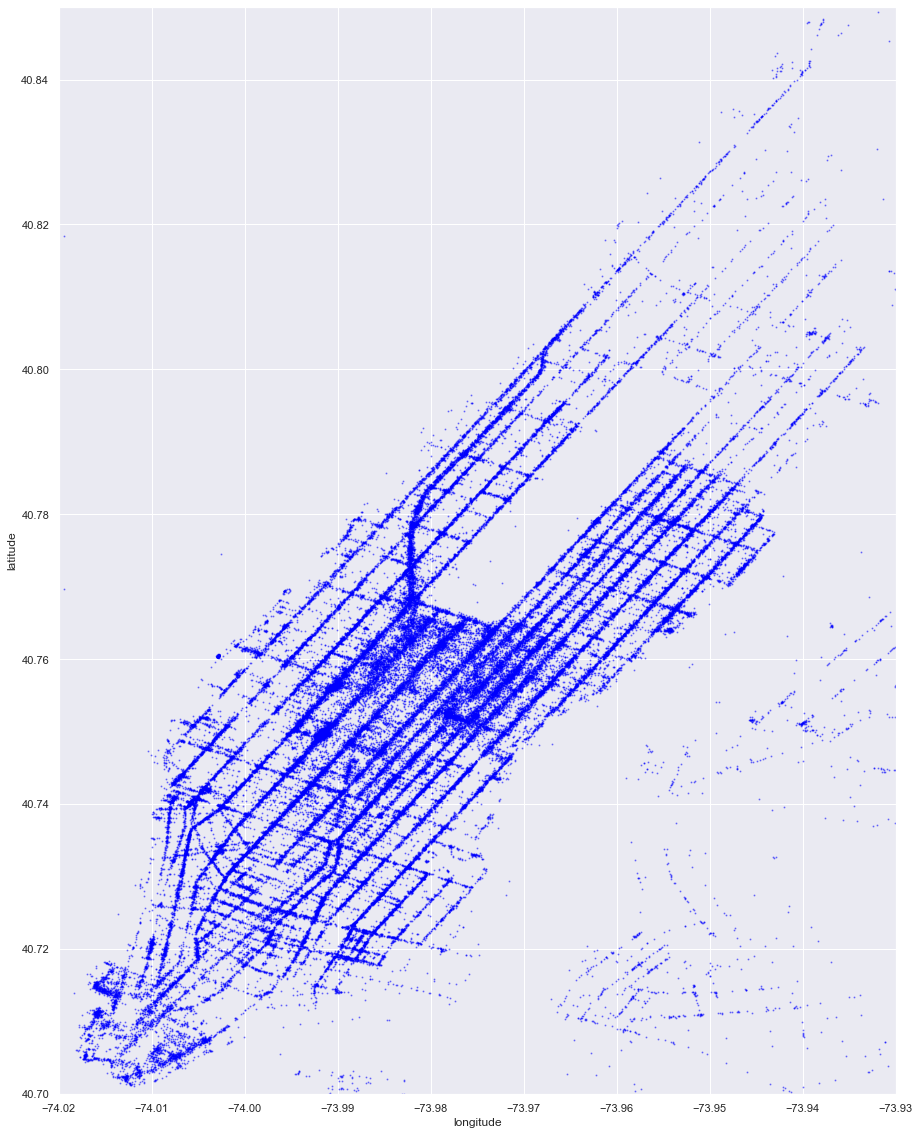

In [68]:
# Найдем координаты нужного прямогольника

N = 100000
city_long_border = (-74.02, -73.93)
city_lat_border = (40.70, 40.85)

plt.figure(figsize=(15,20))
plt.scatter(X_train['pickup_longitude'].values[:N], X_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.4)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin # ПЕРЕПИСАТЬ FIT
import itertools
from itertools import tee

# создать метод FIT

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, up, down, left, right):
        self.up = up
        self.down = down
        self.left = left
        self.right = right 
        self.rectangles = None
        
        
    # создадим разделение
    def create_pair(self, number):
        pair_1, pair_2 = tee(number)
        next(pair_2)
        pair_list = np.array(list((zip(pair_1, pair_2))))
        return pair_list
    
    
    # разделение по вертикали и горизонтали, создание прямоугольников
    def cell_creator(self, horisontal_number, vertical_number):
        
        hor = self.create_pair(
            np.linspace(self.left, self.right, horisontal_number + 1)
        )
        vert = self.create_pair(
            np.linspace(self.down, self.up, vertical_number + 1)
        )
        
        rectangles = np.array(list(itertools.product(hor, vert)))
        self.rectangles = [np.append(rectangles[i], i) for i in range(len(rectangles))]
    
    # создание нового признака
    def fit(self, data, horisontal_number, vertical_number):
        
        self.cell_creator(horisontal_number, vertical_number)
        
        data['cell_start'] = -1
        data['cell_finish']= -1
        
        for i in range(len(self.rectangles)):
            data.loc[
                ((data['pickup_longitude'] >= self.rectangles[i][0]) &
                (data['pickup_longitude'] < self.rectangles[i][1]) &
                (data['pickup_latitude'] < self.rectangles[i][2]) &
                (data['pickup_latitude'] >= self.rectangles[i][3])),
                'cell_start'
            ] = self.rectangles[i][4]
            
            data.loc[
                ((data['dropoff_longitude'] >= self.rectangles[i][0]) &
                (data['dropoff_longitude'] < self.rectangles[i][1]) &
                (data['dropoff_latitude'] < self.rectangles[i][2]) &
                (data['dropoff_latitude'] >= self.rectangles[i][3])),
                'cell_finish'
            ] = self.rectangles[i][4]
            
        return data

In [70]:
# city_long_border = (-74.02, -73.93)
# city_lat_border = (40.70, 40.85)

cells = MapGridTransformer(40.70, 40.85, -74.02, -73.93)

In [71]:
cells.fit(train,3, 6)

vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
96469            2 2016-01-01 00:00:17                5        -73.981743   
223872           1 2016-01-01 00:00:53                1        -73.985085   
713067           2 2016-01-01 00:01:01                5        -73.965279   
652463           1 2016-01-01 00:01:14                1        -73.982292   
722901           1 2016-01-01 00:01:20                1        -73.970108   
...            ...                 ...              ...               ...   
853710           2 2016-06-30 23:58:52                1        -73.982750   
419031           1 2016-06-30 23:59:09                2        -73.955109   
1008720          1 2016-06-30 23:59:10                2        -73.873093   
405743           2 2016-06-30 23:59:37                5        -73.998291   
500524           2 2016-06-30 23:59:39                1        -73.978416   

         pickup_latitude  dropoff_longitude  dropoff_latitude  \
96469          40.719158         -73.938828         40.829182   
223872         40.747166         -73.958038         40.717491   
713067         40.801041         -73.947479         40.815170   
652463         40.751331         -73.991341         40.750340   
722901         40.759800         -73.989357         40.742989   
...                  ...                ...               ...   
853710         40.745289         -73.969002         40.757950   
419031         40.689564         -73.978203         40.685802   
1008720        40.774097         -73.926704         40.856739   
405743         40.722618         -73.971779         40.762470   
500524         40.791576         -73.973160         40.675968   

        store_and_fwd_flag  log_trip_duration  trip  ...  log_haversine  \
96469                    N           6.746412     1  ...       1.923945   
223872                   N           7.167038     1  ...       1.421270   
713067                   N           6.016157     1  ...       1.107331   
652463                   N           5.641907     1  ...       0.696443   
722901                   N           6.603944     1  ...       1.163676   
...                    ...                ...   ...  ...            ...   
853710                   N           6.161207     1  ...       0.946762   
419031                   N           6.628041     1  ...       1.272720   
1008720                  N           7.843064     1  ...       2.012660   
405743                   N           7.275172     1  ...       1.433050   
500524                   N           7.867489     1  ...       1.525267   

          log_v_s  traffic_jam  free_road  from_airport_1  from_airport_2  \
96469   -4.822467            0          0               0               0   
223872  -5.745768            0          0               0               0   
713067  -4.908826            0          0               0               0   
652463  -4.945464            0          0               0               0   
722901  -5.440267            0          0               0               0   
...           ...          ...        ...             ...             ...   
853710  -5.214446            0          0               0               0   
419031  -5.355321            0          0               0               0   
1008720 -5.830404            0          0               1               0   
405743  -5.842122            0          0               0               0   
500524  -6.342222            0          0               0               0   

         to_airport_1  to_airport_2  cell_start  cell_finish  
96469               0             0        11.0         12.0  
223872              0             0        10.0         17.0  
713067              0             0         7.0         13.0  
652463              0             0         9.0          3.0  
722901              0             0         9.0         10.0  
...               ...           ...         ...          ...  
853710              0             0 

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [72]:
print(train.columns[-16:-12])
print(train.columns[-2:])

Index(['dayofweek', 'month', 'hour', 'dayofyear'], dtype='object')
Index(['cell_start', 'cell_finish'], dtype='object')


In [73]:
categorical = list(train.columns[-16:-12]) + list(train.columns[-2:])

numeric_features = train.columns[-11:-9]

In [74]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [75]:
X_train_part = X_train[X_train.columns[-16:]]

X_test_part = X_test[X_test.columns[-16:]]

X_train_part = X_train_part.drop(columns=['log_v_s'])
X_test_part = X_test_part.drop(columns=['log_v_s'])


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features[-1:])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_part, y_train)

y_pred = model.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

# уже значительно лучше чем среднее!

Test RMSE = 0.5496


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
# выглядят достаочно бесполезно. Разве только 9 пьяных пассажиров могут сделать поездку дольше из-за приключений

In [76]:
train['vendor_id'].unique() # 2

array([2, 1])

In [77]:
train['passenger_count'].unique() # 10

array([5, 1, 2, 6, 3, 4, 8, 0, 7, 9])

In [78]:
train['store_and_fwd_flag'].unique() # 2

array(['N', 'Y'], dtype=object)

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

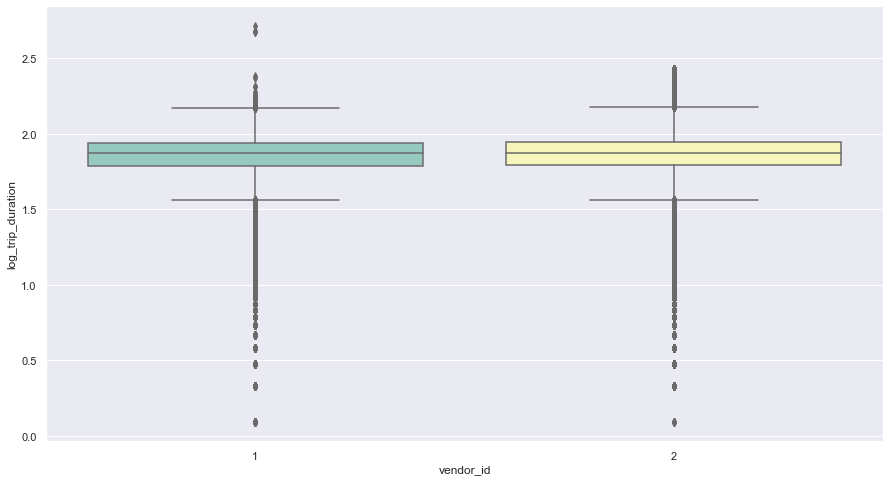

In [79]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="vendor_id", y=np.log(train['log_trip_duration']),
                  data= train, palette="Set3")

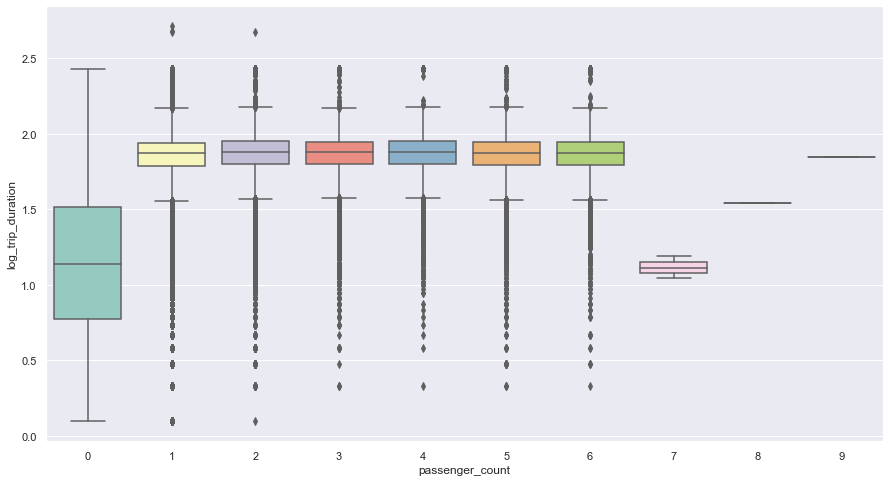

In [80]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="passenger_count", y=np.log(train['log_trip_duration']),
                  data=train, palette="Set3")

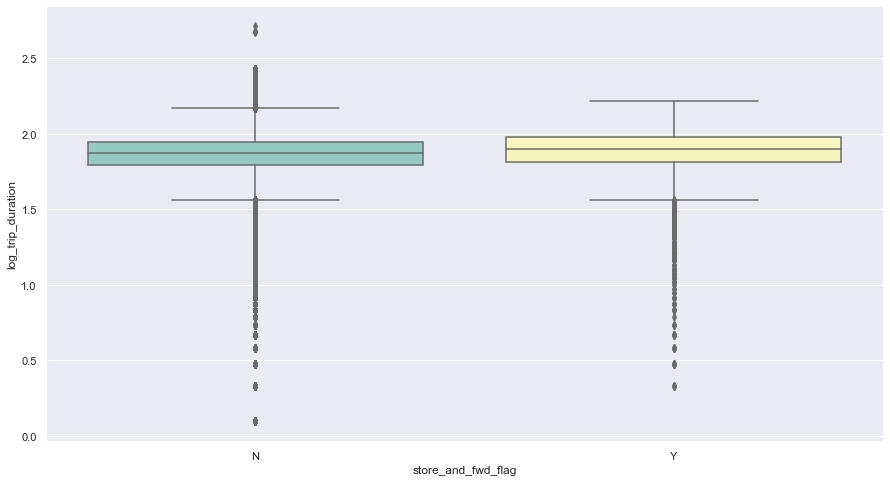

In [81]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(x="store_and_fwd_flag", y=np.log(train['log_trip_duration']),
                  data=train, palette="Set3")

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [82]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['vendor_id'] = lb.fit_transform(train['vendor_id'])
train['store_and_fwd_flag'] = lb.fit_transform(train['store_and_fwd_flag'])

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

In [83]:
# выглядят очень похоже, скорее всего это плохие признаки

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [84]:
categorical = list(train.columns[-16:-12]) + list(train.columns[-2:])

numeric_features = train.columns[-11:-9]

In [85]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [86]:
X_train_part = X_train[list(train.columns[-16:]) + 
                       ['vendor_id', 'passenger_count','store_and_fwd_flag']]

X_test_part = X_test[list(train.columns[-16:]) + 
                     ['vendor_id', 'passenger_count','store_and_fwd_flag']]

X_train_part = X_train_part.drop(columns=['log_v_s'])
X_test_part = X_test_part.drop(columns=['log_v_s'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features[-1:])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_part, y_train)

y_pred = model.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

# признаки никак не повлияли на предсказание

Test RMSE = 0.5496


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [87]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [88]:
train.log_trip_duration.quantile(0.999)

11.351938972439754

In [89]:
train.log_haversine.quantile(0.999)

3.2891463715264173

<AxesSubplot:>

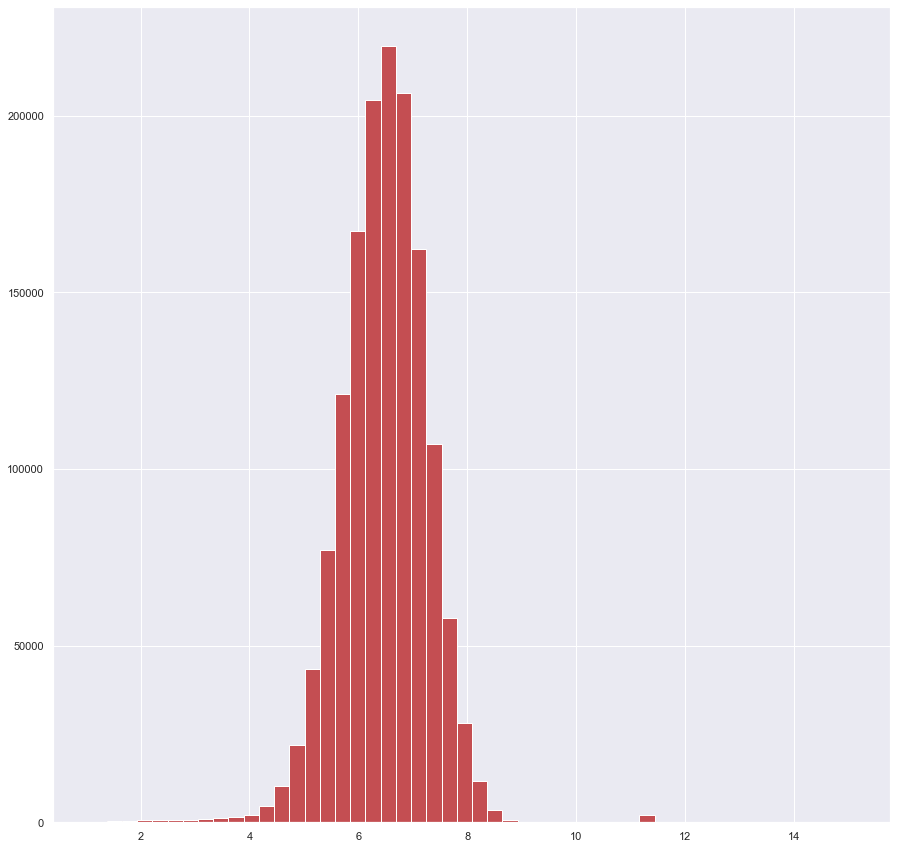

In [90]:
train['log_trip_duration'].hist(bins=50, color='r') 

<AxesSubplot:>

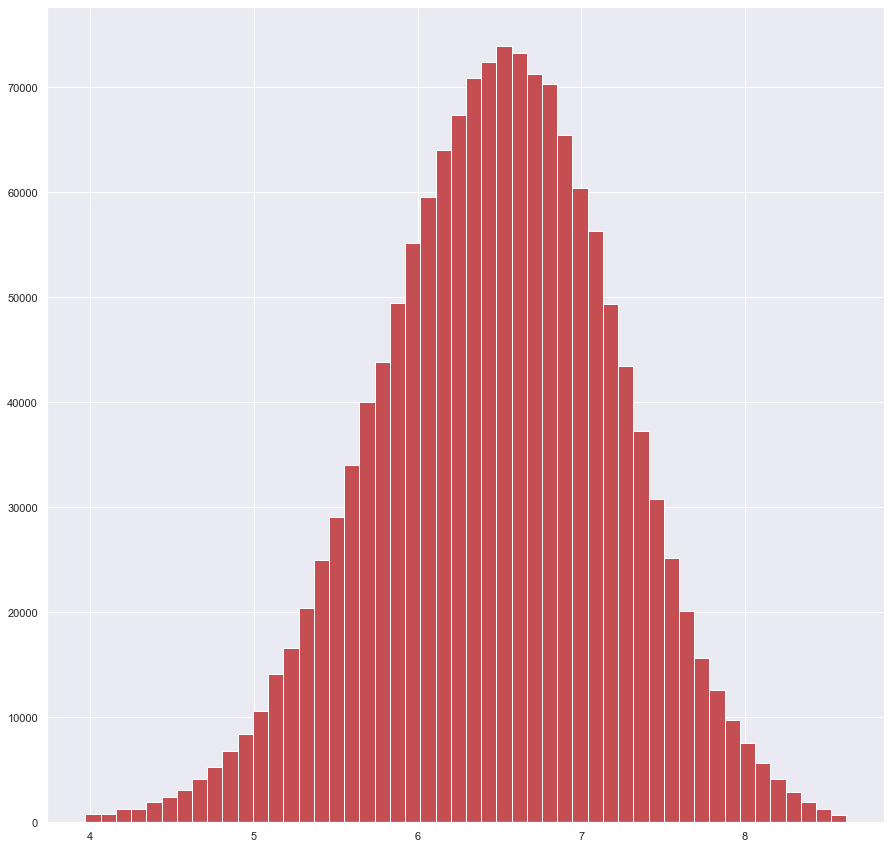

In [91]:
train[
    ((train['log_trip_duration'] < train.log_trip_duration.quantile(0.998))&
    (train['log_trip_duration'] > train.log_trip_duration.quantile(0.005)))
]['log_trip_duration'].hist(bins=50, color='r') 

In [92]:
train = train.drop(
            (
                train[train['log_trip_duration'] < 
                    train.log_trip_duration.quantile(0.005)]
            ).index
)
train = train.drop(
            (
                train[train['log_trip_duration'] > 
                    train.log_trip_duration.quantile(0.998)]
            ).index
)


<AxesSubplot:>

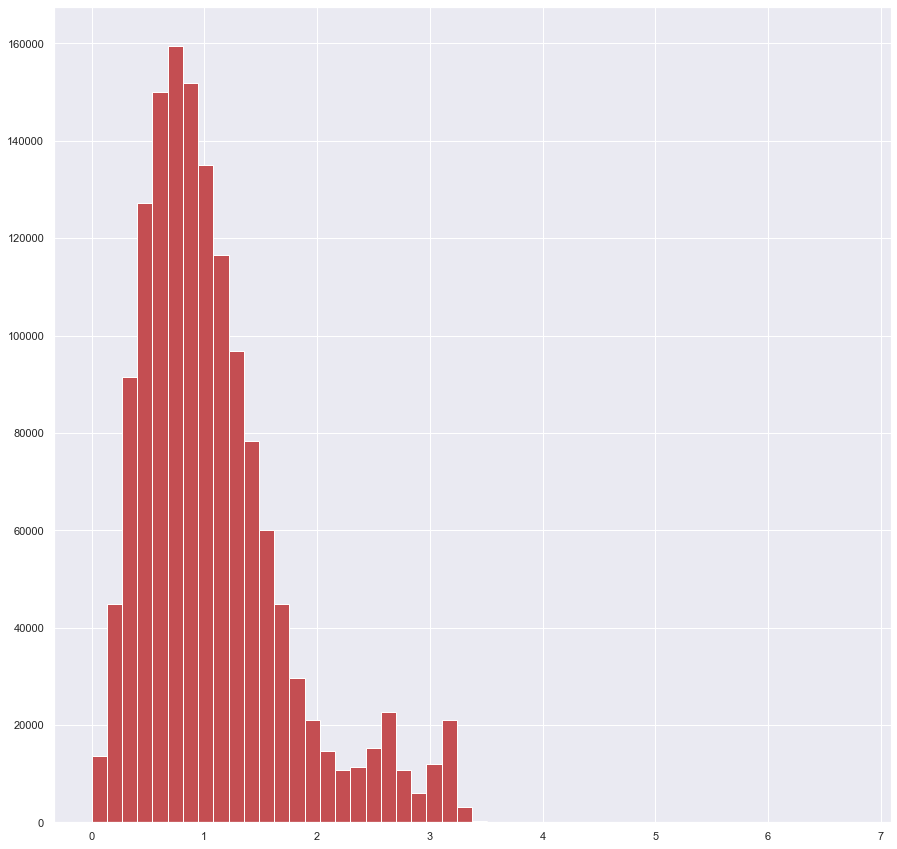

In [93]:
train['log_haversine'].hist(bins=50, color='r') 

<AxesSubplot:>

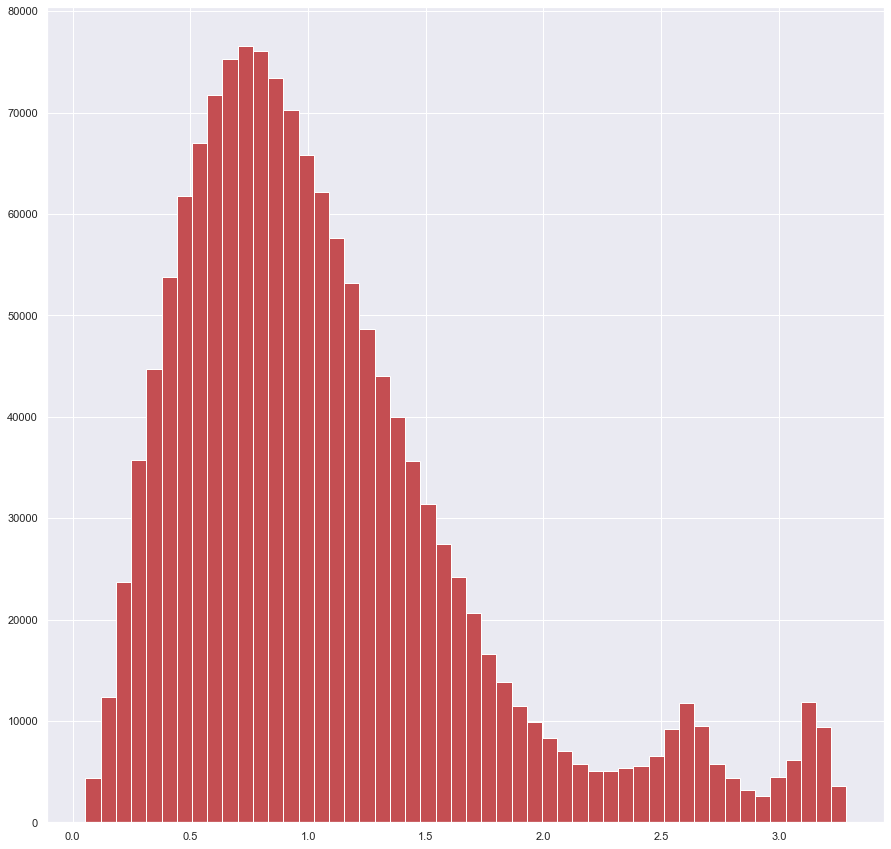

In [94]:
train[
    ((train['log_haversine'] < train.log_haversine.quantile(0.999))&
    (train['log_haversine'] > train.log_haversine.quantile(0.005)))
]['log_haversine'].hist(bins=50, color='r') 

In [95]:
train = train.drop(
            (
                train[train['log_haversine'] < 
                    train.log_haversine.quantile(0.005)]
            ).index
)
train = train.drop(
            (
                train[train['log_haversine'] > 
                    train.log_haversine.quantile(0.999)]
            ).index
)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [96]:
for i in ['cell_finish', 'cell_start', 'passenger_count']:
    unpopular_classes = train[i] \
    .value_counts() \
    [train[i] \
     .value_counts() < 100] \
    .index
    
    for j in unpopular_classes:
        train.loc[train[i] == j, i] = 0.5

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [97]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [98]:
X_train_part = X_train[list(train.columns[-17:])]

X_test_part = X_test[list(train.columns[-17:])]

X_train_part = X_train_part.drop(columns=['log_v_s'])
X_test_part = X_test_part.drop(columns=['log_v_s'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features[-1:])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model_r = pipeline.fit(X_train_part, y_train)

y_pred = model_r.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

# качество стало лучше!

Test RMSE = 0.4773


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [99]:
print("Size before OneHot:", X_train_part.shape)
print("Size after OneHot:", column_transformer.transform(X_train_part).shape)

Size before OneHot: (1007909, 16)
Size after OneHot: (1007909, 253)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [100]:
from sklearn.linear_model import Lasso

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])


model_l = pipeline_lasso.fit(X_train_part, y_train)

y_pred = model_l.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False)) # Ridge значительно лучше

Test RMSE = 0.7246


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [101]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Best alpha = 0.1000


Text(0, 0.5, 'CV score')

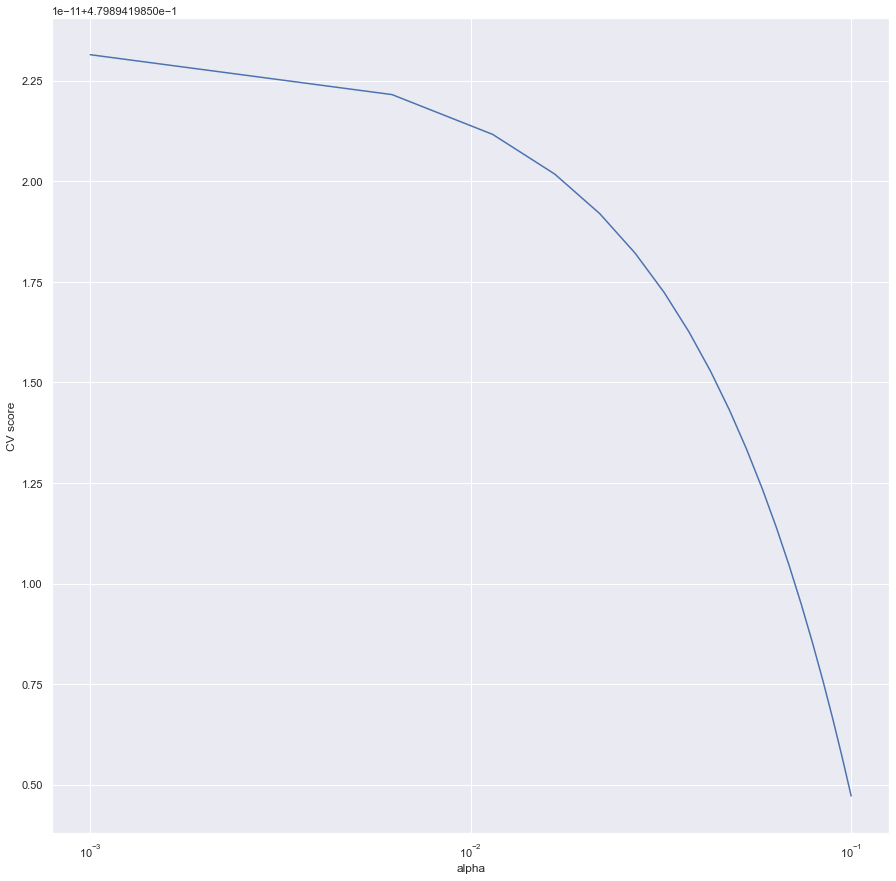

In [102]:
from sklearn.model_selection import GridSearchCV

X_train_part = X_train[list(train.columns[-17:])]
X_train_part = X_train_part.drop(columns=['log_v_s'])

alphas = np.linspace(0.001, 0.1, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_part, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [103]:
X_train_part = X_train[list(train.columns[-17:])]

X_test_part = X_test[list(train.columns[-17:])]

X_train_part = X_train_part.drop(columns=['log_v_s'])
X_test_part = X_test_part.drop(columns=['log_v_s'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features[-1:])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model_l = pipeline_lasso.fit(X_train_part, y_train)
model_r = pipeline.fit(X_train_part, y_train)

In [104]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_l, X_train_part, y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.5225
	-0.5252
	-0.5254
	-0.5238
	-0.5233
	-0.5232
	-0.5250
	-0.5265
	-0.5233
	-0.5229
Mean CV MSE = 0.5241


In [105]:
cv_scores = cross_val_score(model_r, X_train_part, y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.4766
	-0.4791
	-0.4786
	-0.4783
	-0.4776
	-0.4783
	-0.4794
	-0.4790
	-0.4782
	-0.4774
Mean CV MSE = 0.4782


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [106]:
# при больших весах Lasso зануляет вообще все признаки... А при маленьких модель учится вечность
#
zeros = []
for i in range(len(alphas)):
    pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alphas[i]))])
    
    model_l = pipeline_lasso.fit(X_train_part, y_train)

    lasso_zeros = np.sum(pipeline_lasso.steps[-1][-1].coef_ == 0)
    print("Zero weights in Lasso:", lasso_zeros)
    zeros.append(lasso_zeros)


Zero weights in Lasso: 198
Zero weights in Lasso: 241
Zero weights in Lasso: 249
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252
Zero weights in Lasso: 252


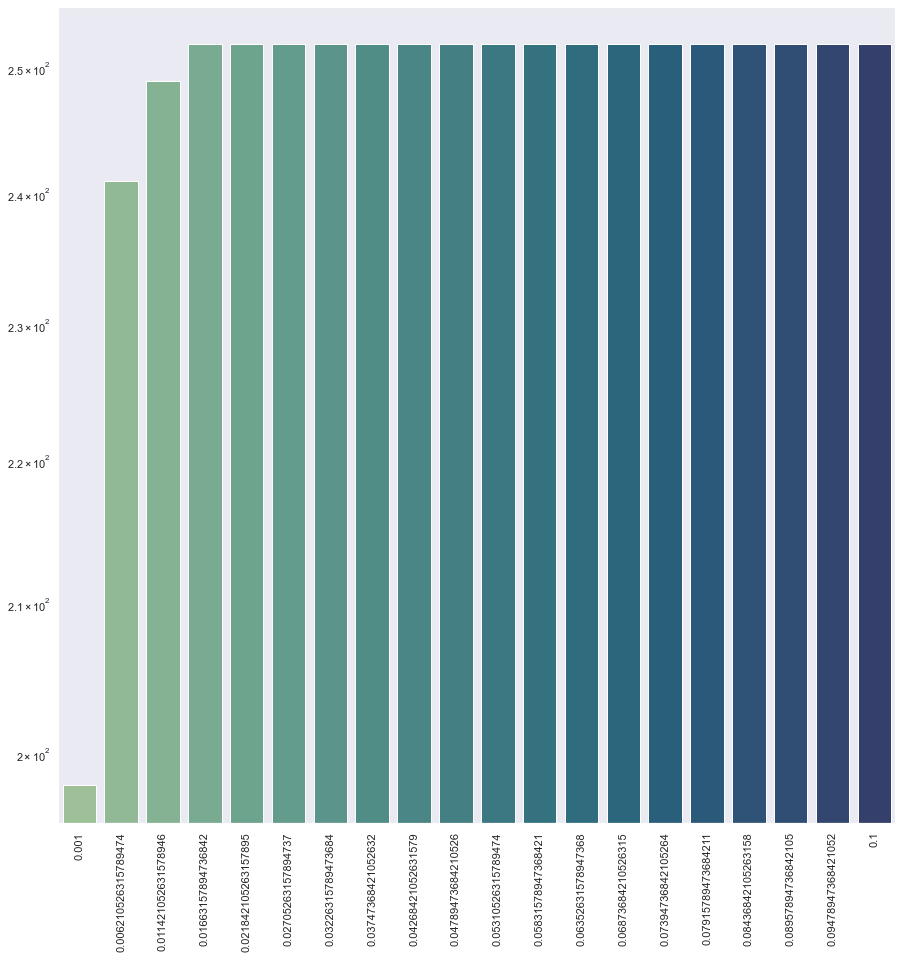

In [107]:
ax = sns.barplot(alphas,zeros, palette='crest')
plt.xticks(rotation=90)
ax.set_yscale('log')

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [108]:
# это изначально нелинейный признак, поэтому регрессия не видит закономерности
# если же мы его укажем напрмямую, это будет хорошим дополнением, потому что для популярных маршрутов будет легче найти взаимосвязь

In [109]:
popular_pairs = pd.DataFrame(
    train.groupby(
        ['cell_start', 'cell_finish']
    )
    .count()
) \
.sort_values( \
    by='vendor_id'\
)[-100:].index

In [110]:
train['popular_pair'] = -1

for i in range(len(popular_pairs)):
    train.loc[((train['cell_start'] == popular_pairs[i][0]) &
             (train['cell_finish'] == popular_pairs[i][1])), 
              'popular_pair'] = i

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [111]:
categorical = list(train.columns[-17:-13]) + list(train.columns[-3:]) 

numeric_features = train.columns[-12:-10]

In [112]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [130]:
categorical

['dayofweek',
 'month',
 'hour',
 'dayofyear',
 'cell_start',
 'cell_finish',
 'popular_pair']

In [131]:
numeric_features

Index(['distance_dummy_manhattan', 'log_distance_dummy_manhattan'], dtype='object')

In [113]:
X_train_part = X_train[list(train.columns[-17:])]

X_test_part = X_test[list(train.columns[-17:])]

X_train_part = X_train_part.drop(columns=['log_v_s'])
X_test_part = X_test_part.drop(columns=['log_v_s'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model_r = pipeline.fit(X_train_part, y_train)

y_pred = model_r.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))



Test RMSE = 0.4368


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [114]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(
    train['pickup_latitude'].values, 
    train['pickup_longitude'].values, 
    train['dropoff_latitude'].values, 
    train['dropoff_longitude'].values
)

In [115]:
train['log_distance_dummy_manhattan'] = np.log1p(train['distance_dummy_manhattan'])

In [116]:
train[['distance_dummy_manhattan', 'log_distance_dummy_manhattan', 'log_haversine','log_trip_duration']].corr() # корелляция значительно выше!

distance_dummy_manhattan  \
distance_dummy_manhattan                      1.000000   
log_distance_dummy_manhattan                  0.902796   
log_haversine                                 0.870312   
log_trip_duration                             0.647915   

                              log_distance_dummy_manhattan  log_haversine  \
distance_dummy_manhattan                          0.902796       0.870312   
log_distance_dummy_manhattan                      1.000000       0.907724   
log_haversine                                     0.907724       1.000000   
log_trip_duration                                 0.775730       0.704561   

                              log_trip_duration  
distance_dummy_manhattan               0.647915  
log_distance_dummy_manhattan           0.775730  
log_haversine                          0.704561  
log_trip_duration                      1.000000

In [117]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=200,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            angle = 100,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

show_circles_on_map(train.sample(1000, random_state=100), "pickup_latitude", "pickup_longitude", "blue")

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [118]:
y = train.log_trip_duration
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [120]:
categorical = list(train.columns[-19:-15]) + list(train.columns[-5:-2]) 
numeric_features = train.columns[-2:]

In [122]:
# стало лучше! Благодаря более точному расстоянию

X_train_part = X_train[list(train.columns[-19:])]

X_test_part = X_test[list(train.columns[-19:])]

X_train_part = X_train_part.drop(columns=['log_haversine', 'haversine', 'log_v_s'])
X_test_part = X_test_part.drop(columns=['log_haversine', 'haversine', 'log_v_s'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model_r = pipeline.fit(X_train_part, y_train)

y_pred = model_r.predict(X_test_part)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.3924


**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [123]:
pip install git+https://github.com/uber/h3-py.git

distutils: /Library/Frameworks/Python.framework/Versions/3.9/include/python3.9/UNKNOWN
sysconfig: /Library/Frameworks/Python.framework/Versions/3.9/include/python3.9
user = False
home = None
root = None
prefix = None
  Cloning https://github.com/uber/h3-py.git to /private/var/folders/5b/j4k5qtvx2j7b9nzkp2clls4c0000gp/T/pip-req-build-oxja579d
  Running command git clone -q https://github.com/uber/h3-py.git /private/var/folders/5b/j4k5qtvx2j7b9nzkp2clls4c0000gp/T/pip-req-build-oxja579d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
distutils: /Library/Frameworks/Python.framework/Versions/3.9/include/python3.9/UNKNOWN
sysconfig: /Library/Frameworks/Python.framework/Versions/3.9/include/python3.9
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m p

In [124]:
from h3 import h3
import folium

In [125]:
# geoJson = {'type': 'Polygon',
#  'coordinates': [[[40.78, -74.006], [40.84 ,  -73.93],[40.785,-73.93], [40.74,-73.97],[40.70, -73.97],[40.70, -74.02]]] }

geoJson = {'type': 'Polygon',
 'coordinates': [[[40.70, -74.02], [40.70 ,  -73.93],[40.85,-73.93], [40.85,-74.02]]] }

#[40.70, -73.93], [40.785,-73.93], [40.72, -73.96]

polyline = geoJson['coordinates'][0]
polyline.append(polyline[0])
lat = [p[0] for p in polyline]
lng = [p[1] for p in polyline]
m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
m.add_child(my_PolyLine)

hexagons = list(h3.polyfill(geoJson, 8))
polylines = []
lat = []
lng = []
for hex in hexagons:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    lat.extend(map(lambda v:v[0],polyline))
    lng.extend(map(lambda v:v[1],polyline))
    polylines.append(polyline)
for polyline in polylines:
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color='red')
    m.add_child(my_PolyLine)
display(m)

In [126]:
class Transformer_h3(BaseEstimator, TransformerMixin):
    def __init__(self, geoJson):
        self.popolylines = []
        self.lat = []
        self.lng = []
        self.hexagons = None
        self.geoJson = geoJson
        
    
    def find_h3(self, lat, lon):
        h3_ = []
        for i in range(len(lat)):
            h3_.append(h3.geo_to_h3(lat[i], lon[i], 8))
        return h3_
    
    # создание шестиугольноиков
    # geoJson - словарь, как в примере выше
    def cell_creator(self):
        
        polyline = self.geoJson['coordinates'][0]
        polyline.append(polyline[0])
        self.lat = [p[0] for p in polyline]
        self.lng = [p[1] for p in polyline]        
        self.hexagons = list(h3.polyfill(self.geoJson, 8))

    # создание нового признака
    def fit(self, data):
        self.cell_creator()
        
        data['cell_start_h3'] = -1
        data['cell_finish_h3']= -1
        data['h3_start'] = self.find_h3(data.pickup_latitude, data.pickup_longitude)
        data['h3_finish'] = self.find_h3(data.dropoff_latitude, data.dropoff_longitude)
        
        for i in range(len(self.hexagons)):
            data.loc[
                data.h3_start == self.hexagons[i],
                'cell_start_h3'
            ] = i
            
        for i in range(len(self.hexagons)):
            data.loc[
                data.h3_finish == self.hexagons[i],
                'cell_finish_h3'
            ] = i
            
        return data

In [127]:
# pol = Transformer_h3(geoJson)
# pol.fit(train)

In [128]:
# ошибка 246, питон просто отказался работать эх!